In [1]:
%%capture
# подгрузка необходимых библиотек
!pip install transformers umap-learn compress-fasttext nltk

In [2]:
%%capture
!!apt-get install -y swig3.0

In [3]:
# Модель корекции текста
%%capture
!gdown 16E4F20pT91hPsrBHHoDG6BP06lgt6IBL
!tar -xvf JamSpellPro-0.9.2.tar.gz

%cd JamSpellPro
!sudo python3 setup.py install

!gdown 1EDegGCzoTPxkEHYRxwR2WhKSx4xGZ358
!tar -xvf ru_med.tar.gz

In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import compress_fasttext
import matplotlib.pyplot as plt

import nltk
import re
import jamspellpro

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [5]:
# Загрузка опернсорс моделей

# Модель получение скрытых состояний
fasttext = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'
)

# Модель анализа тональности
sentiment_model_tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced')
sentiment_model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced')

# Модель корекции текста
corrector = jamspellpro.TSpellCorrector()
assert corrector.LoadLangModel('/content/JamSpellPro/model_ru_med')

In [19]:
# Загрузка обработанного датасета и выбор вопросов для примера
!gdown 1RPdSYh_39L7_fzCRbk0JG274T6V1HpUJ

dataset = pd.read_csv('new_dataset.csv')

data = pd.DataFrame()
data['text'] = dataset[dataset.question == 'В чём причина стресса, по вашему мнению?'].answers

Downloading...
From: https://drive.google.com/uc?id=1RPdSYh_39L7_fzCRbk0JG274T6V1HpUJ
To: /content/new_dataset.csv
100% 3.55M/3.55M [00:00<00:00, 185MB/s]


In [20]:
# словарь english --> russian

qwerty_to_russian = {
    'q': 'й', 'w': 'ц', 'e': 'у', 'r': 'к', 't': 'е', 'y': 'н', 'u': 'г', 'i': 'ш', 'o': 'щ', 'p': 'з',
    'a': 'ф', 's': 'ы', 'd': 'в', 'f': 'а', 'g': 'п', 'h': 'р', 'j': 'о', 'k': 'л', 'l': 'д', ';': 'ж',
    'z': 'я', 'x': 'ч', 'c': 'с', 'v': 'м', 'b': 'и', 'n': 'т', 'm': 'ь', '\\': 'ё',
    'Q': 'Й', 'W': 'Ц', 'E': 'У', 'R': 'К', 'T': 'Е', 'Y': 'Н', 'U': 'Г', 'I': 'Ш', 'O': 'Щ', 'P': 'З',
    'A': 'Ф', 'S': 'Ы', 'D': 'В', 'F': 'А', 'G': 'П', 'H': 'Р', 'J': 'О', 'K': 'Л', 'L': 'Д', ':': 'Ж',
    'Z': 'Я', 'X': 'Ч', 'C': 'С', 'V': 'М', 'B': 'И', 'N': 'Т', 'M': 'Ь', '<': 'Б', '>': 'Ю', '|': 'Ё',
}

# Слова, которые нужно сохранить на английском

english_words_to_keep = {
    "it", "IT", "mephi", "Mephi", "ML",
    "USA", "UK", "UN", "NASA", "EU",
    "NYC", "LA", "DC", "London", "Paris", "Berlin",
    "FBI", "CIA", "NATO", "CSTO" "WHO", "AIDS", "MIPT", "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo", "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)", "Democratic Republic of the Congo ", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "East Timor", "Ecuador",
    "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
    "Haiti", "Holy See","Vatican", "vatican", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
    "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro",
    "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau", "Palestine State",
    "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia",
    "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste (East Timor)", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States of America", "Uruguay", "Uzbekistan",
    "Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe", "Kosovo", "North Cyprus", "Western Sahara", "Taiwan", "Hong Kong", "Macau", "Faroe Islands", "Greenland", "Bermuda", "Puerto Rico", "Guam", "U.S. Virgin Islands", "American Samoa", "Northern Mariana Islands",
    "Falkland Islands", "South Georgia and the South Sandwich Islands", "Cook Islands", "Niue", "Tokelau", "Abkhazia", "South Ossetia", "Sahrawi Arab Democratic Republic", "Kosovo", "Nagorno-Karabakh", "afghanistan", "albania", "algeria", "andorra", "angola", "antigua and barbuda",
    "argentina", "armenia", "australia", "austria", "azerbaijan", "bahamas", "bahrain", "bangladesh", "barbados", "belarus", "belgium", "belize", "benin", "bhutan", "bolivia", "bosnia and herzegovina", "botswana", "brazil", "brunei", "bulgaria", "burkina faso", "burundi",
    "cabo verde", "cambodia", "cameroon", "canada", "central african republic", "chad", "chile", "china", "colombia", "comoros", "congo (congo-brazzaville)", "costa rica", "croatia", "cuba", "cyprus", "czechia", "czech republic" "democratic republic of the congo ",
    "denmark", "djibouti", "dominica", "dominican republic", "east timor ", "ecuador", "egypt", "el salvador",
    "equatorial guinea", "eritrea", "estonia", "eswatini", "ethiopia", "fiji", "finland", "france", "gabon",
    "gambia", "georgia", "germany", "ghana", "greece", "grenada", "guatemala", "guinea", "guinea-bissau", "guyana", "haiti", "holy see", "honduras", "hungary", "iceland",
    "india", "indonesia", "iran", "iraq", "ireland", "israel", "italy", "ivory coast", "jamaica", "japan", "jordan", "kazakhstan", "kenya", "kiribati",
    "kuwait", "kyrgyzstan", "laos", "latvia", "lebanon", "lesotho", "liberia", "libya", "liechtenstein", "lithuania", "luxembourg", "madagascar", "malawi", "malaysia", "maldives", "mali", "malta", "marshall islands", "mauritania",
    "mauritius", "mexico", "micronesia", "moldova", "monaco", "mongolia", "montenegro", "morocco", "mozambique", "myanmar ", "namibia", "nauru", "nepal", "netherlands", "new zealand",
    "nicaragua", "niger", "nigeria", "north korea", "north macedonia (formerly macedonia)", "norway", "oman", "pakistan", "palau", "palestine state", "panama", "papua new guinea", "paraguay",
    "peru", "philippines", "poland", "portugal", "qatar", "romania", "russia", "rwanda", "saint kitts and nevis", "saint lucia", "saint vincent and the grenadines", "samoa", "san marino",
    "sao tome and principe", "saudi arabia", "senegal", "serbia", "seychelles", "sierra leone", "singapore", "slovakia", "slovenia", "solomon islands", "somalia", "south africa",
    "south korea", "south sudan", "spain", "sri lanka", "sudan", "suriname", "sweden", "switzerland", "syria", "tajikistan", "tanzania", "thailand",
    "timor-leste (east timor)", "togo", "tonga", "trinidad and tobago", "tunisia", "turkey", "turkmenistan", "tuvalu", "uganda", "ukraine", "united arab emirates",
    "united kingdom", "united states of america", "uruguay", "uzbekistan", "vanuatu", "venezuela", "vietnam", "yemen", "zambia", "zimbabwe", "kosovo", "north cyprus",
    "western sahara", "taiwan", "hong kong", "macau", "faroe islands", "greenland", "bermuda", "puerto rico", "guam", "u.s. virgin islands", "american samoa",
    "northern mariana islands", "falkland islands", "south georgia and the south sandwich islands", "cook islands", "niue", "tokelau", "abkhazia", "south ossetia",
    "sahrawi arab democratic republic", "kosovo", "nagorno-karabakh", "Adygea", "Altai Republic", "Altai Krai", "Amur Oblast", "Arkhangelsk Oblast", "Astrakhan Oblast", "Bashkortostan",
    "Belgorod Oblast", "Bryansk Oblast", "Buryatia", "Chechnya", "Chelyabinsk Oblast", "Chukotka Autonomous Okrug", "Chuvashia", "Dagestan", "Ingushetia", "Irkutsk Oblast",
    "Ivanovo Oblast", "Jewish Autonomous Okrug", "Kabardino-Balkaria", "Kaliningrad Oblast", "Kalmykia", "Kaluga Oblast", "Kamchatka Krai", "Karachay-Cherkessia",
    "Karelia", "Kemerovo Oblast", "Khabarovsk Krai", "Khakassia", "Khanty-Mansi Autonomous Okrug", "Kirov Oblast", "Komi", "Kostroma Oblast", "Krasnodar Krai",
    "Krasnoyarsk Krai", "Kurgan Oblast", "Kursk Oblast", "Leningrad Oblast", "Lipetsk Oblast", "Magadan Oblast", "Mari El Republic", "Mordovia", "Moscow", "Moscow Oblast",
    "Murmansk Oblast", "Nenets Autonomous Okrug", "Nizhny Novgorod Oblast", "North Ossetia-Alania", "Novgorod Oblast", "Novosibirsk Oblast", "Omsk Oblast", "Orenburg Oblast",
    "Oryol Oblast", "Penza Oblast", "Perm Krai", "Primorsky Krai", "Pskov Oblast", "Rostov Oblast", "Ryazan Oblast", "Sakha Republic", "Yakutia", "Sakhalin Oblast",
    "Saratov Oblast", "Smolensk Oblast", "Stavropol Krai", "Sverdlovsk Oblast", "Taimyr Autonomous Okrug", "Tatarstan", "Tomsk Oblast", "Tula Oblast", "Tuva", "Tver Oblast",
    "Tyumen Oblast", "Ulyanovsk Oblast", "Vladimir Oblast", "Volgograd Oblast", "Vologda Oblast", "Voronezh Oblast", "Yamalo-Nenets Autonomous Okrug", "Yaroslavl Oblast",
    "Zabaykalsky Krai", "Republic of Udmurtia", "Donetsk People's Republic", "DPR", "Donetsk", "Luhansk People's Republic", "LPR", "Luhansk", "Kherson Oblast", "Zaporizhzhia Oblast",
    "Kharkiv Oblast", "Odessa Oblast", "Nikolaev Oblast", "Kryvyi Rih Oblast", "Nikolaev", "Kryvyi Rih", "Odessa", "Kharkiv", "Zaporizhzhia", "Kherson",
    "Moscow", "Saint Petersburg", "Yekaterinburg", "Nizhny Novgorod", "Novosibirsk", "Krasnoyarsk", "Perm", "Kazan", "Samara", "Ufa", "Saratov", "Rostov-on-Don",
    "Chelyabinsk", "Vladivostok", "Omsk", "Murmansk", "Kaliningrad", "Irkutsk", "Khabarovsk", "Tyumen", "Magadan", "Yoshkar-Ola", "Penza", "Yekaterinburg",
    "Nizhny Novgorod", "Saint Petersburg", "Novosibirsk", "Vladivostok", "Krasnodar", "Krasnoyarsk", "Kurgan", "Kursk", "Arkhangelsk", "Yoshkar-Ola", "Kaliningrad",
    "Kyzyl", "Pskov", "Rostov-on-Don", "Yakutsk", "Yuzhno-Sakhalinsk", "Saratov", "Grozny", "Magas", "Chelyabinsk", "Yekaterinburg", "Yoshkar-Ola", "Kaluga",
    "Petropavlovsk-Kamchatsky", "Cherkessk", "Petrozavodsk", "Kemerovo", "Khabarovsk", "Abakan", "Syktyvkar", "Kostroma", "Krasnodar", "Irkutsk", "Ivanovo",
    "Elista", "Kaluga", "Nalchik", "Kaliningrad", "Kyzyl", "Saransk", "Ryazan", "Vladikavkaz", "Yekaterinburg", "Yoshkar-Ola", "Nizhny Novgorod", "Pskov",
    "Stavropol", "Yuzhno-Sakhalinsk", "Kirov", "Kursk", "Astrakhan", "Grozny", "Magas", "Chelyabinsk", "Yekaterinburg", "Nizhny Novgorod", "Krasnodar",
    "Krasnoyarsk", "Kurgan", "Kursk", "Saint Petersburg", "Lipetsk", "Anadyr", "Pskov", "Rostov-on-Don", "Yakutsk", "Yuzhno-Sakhalinsk", "Saratov",
    "Grozny", "Magas", "Chelyabinsk", "Yekaterinburg", "Nizhny Novgorod", "Saint Petersburg", "Novosibirsk", "Vladivostok", "Krasnodar", "Krasnoyarsk",
    "Kurgan", "Kursk", "Leningrad", "Lipetsk", "Magadan", "Yoshkar-Ola", "Penza", "Petrozavodsk", "Kemerovo", "Khabarovsk", "Abakan", "Syktyvkar", "Kostroma",
    "Krasnodar", "Irkutsk", "Ivanovo", "Elista", "Kaluga", "Nalchik", "Kaliningrad", "Kyzyl", "Saransk", "Ryazan", "Vladikavkaz", "Yekaterinburg",
    "Yoshkar-Ola", "Nizhny Novgorod", "Pskov", "Stavropol", "Yuzhno-Sakhalinsk", "Kirov", "Kursk", "Astrakhan", "Grozny", "Magas", "MSU", "SPBU", "MIPT", "MGIMO",
    "HSE", "ITMO", "MEPhI", "BMSTU", "NSU", "TSU", "KFU", "NRU HSE", "SPbPU", "SUAI", "TSU", "SFU", "SSAU", "RANEPA", "URFU", "VSUES",
    "msu", "spbu", "mipt", "mgimo", "hse", "itmo", "mephi", "bmstu", "nsu", "tsu", "kfu", "nru hse", "spbpu", "suai", "tsu", "sfu", "ssau", "ranepa", "urfu", "vsues"
}

znaki = {',': 'б', '.': 'ю',}

def is_znaki_needed(word, char):
  index = word.index(char)
  if index in range(1, len(word) - 1):
    return znaki[char]
  return char

# функция для исправления опечаток из-за раскладки
def en_to_ru(text):
    words = re.split("\s", text)
    converted_words = []

    for word in words:
        if re.sub("[,.]", "", word.lower()) in english_words_to_keep:
            # Если слово из списка, сохраняем его как есть
            converted_words.append(word)
        else:
            # Иначе, заменяем символы внутри слова
            converted_word = ''
            for char in word:
                if char.lower() in qwerty_to_russian:
                      if char.isupper():
                          converted_word += qwerty_to_russian[char.lower()].upper()
                      else:
                          converted_word += qwerty_to_russian[char.lower()]
                elif char in znaki:
                    converted_word += is_znaki_needed(word, char)
                else:
                    converted_word += char
            converted_words.append(converted_word)

    return ' '.join(converted_words)

In [11]:
# функция удаления ненормативной лексики и нормализации строки ()
!gdown 1zsHfHSloG15AVEl6XE4oqllSbe1bApN8

restricted = open("/content/restricted.txt", "r").read().split(" ")

def rid_restricted(sent):
  return " ".join([word for word in sent.split(" ") if word not in restricted])

def correct(sentence):
  return corrector.FixFragment(en_to_ru(re.sub(f"[#$%^&*\(\)\[\]]", "", sentence)))

Downloading...
From: https://drive.google.com/uc?id=1zsHfHSloG15AVEl6XE4oqllSbe1bApN8
To: /content/restricted.txt
100% 5.21k/5.21k [00:00<00:00, 13.6MB/s]


In [ ]:
#Начало Обработки

data['text'] = data['text'].apply(lambda x: rid_restricted(correct(x)))

In [ ]:
# Оценка тональности
tokens = sentiment_model_tokenizer(list(data['text']), padding=True, truncation=True, return_tensors='pt')
sentiments = torch.argmax(sentiment_model(**tokens).logits, dim=1)
data['sentiment'] = sentiments

data['sentiment'] = data['sentiment'].apply(lambda x: sentiment_model.config.id2label[x])

In [ ]:
# Получение эмбедингов
data['embeds'] = list(fasttext[list(data['text'])])

In [ ]:
# Понижение размерности до 2d
reducer2d = umap.UMAP(n_components=2)

umap_embeds = reducer2d.fit_transform(list(data['embeds']))
data['embeds'] = list(umap_embeds)

In [ ]:
# Агломеративная класетризация
agg_clusterer = AgglomerativeClustering(n_clusters = None, distance_threshold=0.5)
labels = agg_clusterer.fit_predict(list(data['embeds']))

data['cluster'] = labels

#конец Обработки

In [ ]:
# Сбор показаний
grouped = data.groupby('cluster').count().reset_index()

mean_group_count = int(grouped['text'].sum() / len(data['cluster'].unique()))
group_count = len(data['cluster'].unique())

max_cluster = grouped[grouped.text == grouped.text.max()]
max_cluster_count = int(max_cluster['text'].iloc[0])
top_elemnts = list(data[data['cluster'] == max_cluster.iloc[0, 0]].text[:4])

print('Среднее число элементов в кластере:', mean_group_count)
print('Количество кластеров:', group_count)
print()
print('Максимальный кластер содержит элементов: ', max_cluster_count)
print('Например: ', ', '.join(top_elemnts))

Среднее число элементов в кластере: 3
Количество кластеров: 83

Максимальный кластер содержит элементов:  9
Например:  большая нагрузка, большой нагрузке, высокая нагрузка, нагрузка


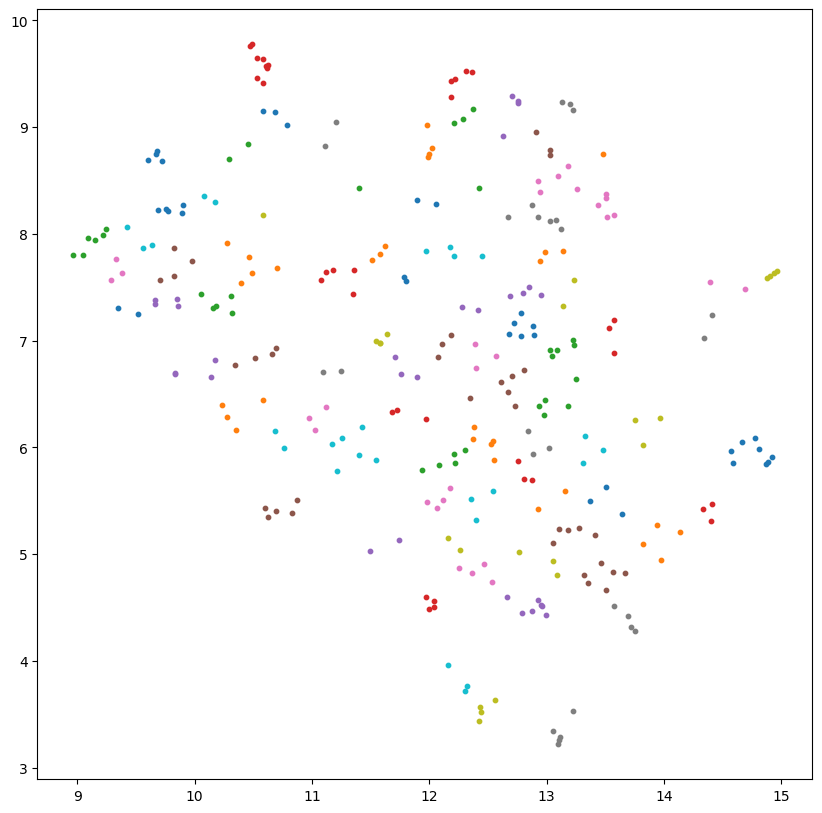

In [ ]:
# Визуализация пространства
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

for cluster in data.cluster.unique():
    em = np.array(list(data[data.cluster == cluster]['embeds']))
    ax.scatter(em[:, 0], em[:, 1], s=10)

In [ ]:
list(data[data.cluster == 78].text)

['зеленогорск', 'краснокаменск', 'зеленогорск', 'краснокаменск']

In [ ]:
data.to_csv('main_v1.csv', index=False)